# World Bank Dataset

You are a team of data analysts working for the World Bank’s Development Data Division. Your assignment is to prepare a clear, data-driven report comparing key indicators of sustainable development across the four global income groups (Low, Lower-Middle, Upper-Middle, and High).
Your goal is to examine how countries at different income levels perform across multiple spheres of sustainability — including governance, environmental sustainability, economic stability and prosperity, and human well-being. This is a comparative analysis aimed at identifying systematic differences between income groups, not predicting or explaining causality. Make sure of using the relevant statistical test under the correct assumptions.

In your report, **explore indicators that capture the diversity of sustainability dimensions** — for example:

* **Governance and institutional quality** (e.g., government effectiveness, control of corruption, rule of law)
* **Environmental sustainability** (e.g., CO₂ emissions, renewable energy use, forest and agricultural land, environmental expenditure)
* **Economic performance and poverty reduction** (e.g., GDP, inflation, tax revenue, poverty headcount, unemployment)
* **Human well-being and health** (e.g., life expectancy, education expenditure, access to electricity, population density)


Use the data to compare income groups and discuss how **development patterns differ across these sustainability domains**. Highlight where disparities are most pronounced, and where certain groups show surprising strengths or weaknesses.


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import math
import numpy as np

# Import libraries for running ANOVA and post-hoc test
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Import Data

* Read files
* Create a mapping table of countries in both tables
* Copy income column to world bank data


In [7]:
# Income Data

df_income = pd.read_excel('../additional_material/week_05_income.xlsx', sheet_name='List of economies')

display(df_income.head())

,Economy,Code,Region,Income group,Lending category
0,Afghanistan,AFG,"Middle East, North Africa, Afghanistan & Pakistan",Low income,IDA
1,Albania,ALB,Europe & Central Asia,Upper middle income,IBRD
2,Algeria,DZA,"Middle East, North Africa, Afghanistan & Pakistan",Upper middle income,IBRD
3,American Samoa,ASM,East Asia & Pacific,High income,NaN
4,Andorra,AND,Europe & Central Asia,High income,NaN


In [8]:
# Exploration of Income Data – List of countries


subset = df_income.iloc[:218]

unique_vals = subset['Economy'].unique()
count_unique = subset['Economy'].nunique()

print("Unique values:", unique_vals)
print("Count:", count_unique)


Unique values: ['Afghanistan' 'Albania' 'Algeria' 'American Samoa' 'Andorra' 'Angola'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Aruba' 'Australia' 'Austria'
 'Azerbaijan' 'Bahamas, The' 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus'
 'Belgium' 'Belize' 'Benin' 'Bermuda' 'Bhutan' 'Bolivia'
 'Bosnia and Herzegovina' 'Botswana' 'Brazil' 'British Virgin Islands'
 'Brunei Darussalam' 'Bulgaria' 'Burkina Faso' 'Burundi' 'Cabo Verde'
 'Cambodia' 'Cameroon' 'Canada' 'Cayman Islands'
 'Central African Republic' 'Chad' 'Channel Islands' 'Chile' 'China'
 'Colombia' 'Comoros' 'Congo, Dem. Rep.' 'Congo, Rep.' 'Costa Rica'
 'Côte d’Ivoire' 'Croatia' 'Cuba' 'Curaçao' 'Cyprus' 'Czechia' 'Denmark'
 'Djibouti' 'Dominica' 'Dominican Republic' 'Ecuador' 'Egypt, Arab Rep.'
 'El Salvador' 'Equatorial Guinea' 'Eritrea' 'Estonia' 'Eswatini'
 'Ethiopia' 'Faroe Islands' 'Fiji' 'Finland' 'France' 'French Polynesia'
 'Gabon' 'Gambia, The' 'Georgia' 'Germany' 'Ghana' 'Gibraltar' 'Greece'
 'Greenland' 'Grenada' 'G

In [9]:
df_wb = pd.read_csv('../additional_material/week_05_world_bank_development_indicators.csv')

In [10]:
df_wb['country'].unique()

array(['Afghanistan', 'Africa Eastern and Southern',
       'Africa Western and Central', 'Albania', 'Algeria',
       'American Samoa', 'Andorra', 'Angola', 'Antigua and Barbuda',
       'Arab World', 'Argentina', 'Armenia', 'Aruba', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas, The', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda',
       'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana',
       'Brazil', 'British Virgin Islands', 'Brunei Darussalam',
       'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia',
       'Cameroon', 'Canada', 'Caribbean small states', 'Cayman Islands',
       'Central African Republic', 'Central Europe and the Baltics',
       'Chad', 'Channel Islands', 'Chile', 'China', 'Colombia', 'Comoros',
       'Congo, Dem. Rep.', 'Congo, Rep.', 'Costa Rica', "Cote d'Ivoire",
       'Croatia', 'Cuba', 'Curacao', 'Cyprus', 'Czech Republic',
       'Czechia', 'Denmark', 'Djibouti', 'Dominica'

## Find difference in countries before merging

In [11]:
# extract country lists
income_countries = set(df_income['Economy'].unique())
wb_countries     = set(df_wb['country'].unique())

# countries in WB but not in Income table
missing_in_income = sorted(wb_countries - income_countries)

missing_in_income


["Cote d'Ivoire",
 'Curacao',
 'Czech Republic',
 'East Asia & Pacific (IDA & IBRD countries)',
 'Europe & Central Asia (IDA & IBRD countries)',
 'Latin America & the Caribbean (IDA & IBRD countries)',
 'Middle East & North Africa',
 'Middle East & North Africa (IDA & IBRD countries)',
 'Middle East & North Africa (IDA & IBRD)',
 'Middle East & North Africa (excluding high income)',
 'Not classified',
 'Puerto Rico',
 'Sao Tome and Principe',
 'Somalia',
 'Sub-Saharan Africa (IDA & IBRD countries)',
 'Turkey',
 'Turkiye',
 'Viet Nam']

In [12]:
income_to_wb_mapping = {
    # Abweichende Schreibweisen
    "Côte d’Ivoire": "Cote d'Ivoire",
    "Curaçao": "Curacao",
    "Czechia": "Czech Republic",
    "São Tomé and Príncipe": "Sao Tome and Principe",
    "Somalia, Fed. Rep.": "Somalia",
    "Türkiye": "Turkey",
    "Vietnam": "Viet Nam",
    "Puerto Rico (U.S.)": "Puerto Rico",

    # Regionen und Gruppen (Income → WB)
    "East Asia & Pacific (IDA & IBRD)":
        "East Asia & Pacific (IDA & IBRD countries)",

    "Europe & Central Asia (IDA & IBRD)":
        "Europe & Central Asia (IDA & IBRD countries)",

    "Latin America & Caribbean (IDA & IBRD)":
        "Latin America & the Caribbean (IDA & IBRD countries)",

    "Sub-Saharan Africa (IDA & IBRD)":
        "Sub-Saharan Africa (IDA & IBRD countries)",

    "Middle East, North Africa, Afghanistan & Pakistan":
        "Middle East & North Africa",

    "Middle East, North Africa, Afghanistan and Pakistan (IDA & IBRD)":
        "Middle East & North Africa (IDA & IBRD countries)",

    "Middle East, North Africa, Afghanistan and Pakistan (excluding high income)":
        "Middle East & North Africa (excluding high income)",

    "Not classified": "Not classified"
}


In [13]:
df_income['Economy_cleaned'] = df_income['Economy'].replace(income_to_wb_mapping)


In [14]:
income_cleaned = set(df_income['Economy_cleaned'].unique())
wb_countries = set(df_wb['country'].unique())

missing_after_cleanup = sorted(wb_countries - income_cleaned)

missing_after_cleanup

['Czechia',
 'East Asia & Pacific (IDA & IBRD)',
 'Europe & Central Asia (IDA & IBRD)',
 'Latin America & Caribbean (IDA & IBRD)',
 'Middle East & North Africa',
 'Middle East & North Africa (IDA & IBRD)',
 'Not classified',
 'Sub-Saharan Africa (IDA & IBRD)',
 'Turkiye',
 'Vietnam']

In [15]:
income_meta = df_income[['Economy_cleaned', 'Region', 'Income group', 'Lending category']]


In [16]:
df_wb = df_wb.merge(
    income_meta,
    how='left',
    left_on='country',
    right_on='Economy_cleaned'
)


In [17]:
df_wb.drop(columns='Economy_cleaned')

,country,date,agricultural_land%,forest_land%,land_area,avg_precipitation,trade_in_services%,control_of_corruption_estimate,control_of_corruption_std,access_to_electricity%,...,death_rate,life_expectancy_at_birth,population,rural_population,voice_and_accountability_estimate,voice_and_accountability_std,intentional_homicides,Region,Income group,Lending category
0,Afghanistan,1960-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,31.921,32.535,8622466.0,7898093.0,NaN,NaN,NaN,"Middle East, North Africa, Afghanistan & Pakistan",Low income,IDA
1,Afghanistan,1961-01-01,57.878356,NaN,652230.0,327.0,NaN,NaN,NaN,NaN,...,31.349,33.068,8790140.0,8026804.0,NaN,NaN,NaN,"Middle East, North Africa, Afghanistan & Pakistan",Low income,IDA
2,Afghanistan,1962-01-01,57.955016,NaN,652230.0,327.0,NaN,NaN,NaN,NaN,...,30.845,33.547,8969047.0,8163985.0,NaN,NaN,NaN,"Middle East, North Africa, Afghanistan & Pakistan",Low income,IDA
3,Afghanistan,1963-01-01,58.031676,NaN,652230.0,327.0,NaN,NaN,NaN,NaN,...,30.359,34.016,9157465.0,8308019.0,NaN,NaN,NaN,"Middle East, North Africa, Afghanistan & Pakistan",Low income,IDA
4,Afghanistan,1964-01-01,58.116002,NaN,652230.0,327.0,NaN,NaN,NaN,NaN,...,29.867,34.494,9355514.0,8458694.0,NaN,NaN,NaN,"Middle East, North Africa, Afghanistan & Pakistan",Low income,IDA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17267,Zimbabwe,2019-01-01,41.876696,45.213002,386850.0,657.0,6.927164,-1.271190,0.133336,46.682095,...,8.043,61.292,15354608.0,10408889.0,-1.163669,0.117815,5.145035,Sub-Saharan Africa,Lower middle income,Blend
17268,Zimbabwe,2020-01-01,41.876696,45.093912,386850.0,657.0,5.118949,-1.287992,0.140076,52.747667,...,8.132,61.124,15669666.0,10617452.0,-1.113408,0.120230,4.977770,Sub-Saharan Africa,Lower middle income,Blend
17269,Zimbabwe,2021-01-01,41.876696,44.974822,386850.0,NaN,NaN,-1.253550,0.151591,48.979927,...,9.057,59.253,15993524.0,10827136.0,-1.135830,0.120300,6.139985,Sub-Saharan Africa,Lower middle income,Blend
17270,Zimbabwe,2022-01-01,NaN,NaN,NaN,NaN,NaN,-1.255139,0.151262,NaN,...,NaN,NaN,16320537.0,11033499.0,-1.102206,0.119338,NaN,Sub-Saharan Africa,Lower middle income,Blend


Income Data is merged into the World Bank Dataset now.

In [18]:
df_wb.describe()

,agricultural_land%,forest_land%,land_area,avg_precipitation,trade_in_services%,control_of_corruption_estimate,control_of_corruption_std,access_to_electricity%,renewvable_energy_consumption%,electric_power_consumption,...,multidimensional_poverty_headcount_ratio%,gini_index,birth_rate,death_rate,life_expectancy_at_birth,population,rural_population,voice_and_accountability_estimate,voice_and_accountability_std,intentional_homicides
count,14714.000000,8176.000000,1.493000e+04,10086.000000,9195.000000,4783.000000,4783.000000,7348.000000,8076.000000,7790.000000,...,455.000000,2108.000000,16037.000000,16019.000000,15866.000000,1.666500e+04,1.653900e+04,4850.000000,4850.000000,4209.000000
mean,36.945264,32.408397,5.078664e+06,1214.021416,20.998956,-0.024874,0.203572,80.758176,31.029558,2885.204630,...,27.058386,37.797249,28.203391,10.490354,64.254193,2.159737e+08,1.231026e+08,-0.021062,0.167144,8.035708
std,20.552401,23.355506,1.406167e+07,810.573031,23.260442,1.000047,0.087529,28.745226,29.858553,4103.108667,...,11.262910,8.835216,12.862546,5.358976,11.112156,7.102653e+08,4.087475e+08,0.998757,0.064188,12.026623
min,0.262821,0.000000,2.027000e+00,18.100000,0.621025,-1.936706,0.114062,0.533899,0.000000,5.548906,...,2.370000,20.700000,5.000000,0.795000,11.995000,2.646000e+03,0.000000e+00,-2.313395,0.102437,0.000000
25%,20.454545,12.430556,2.164000e+04,591.000000,8.678157,-0.791694,0.147978,68.435427,5.065460,375.934172,...,18.300000,31.200000,16.438000,6.976522,56.810602,9.940000e+05,4.295845e+05,-0.850328,0.126422,1.348194
50%,37.470745,30.765419,2.419300e+05,1110.000000,13.456865,-0.253887,0.172218,98.290939,20.989980,1331.112025,...,24.800000,35.700000,27.065000,9.200000,66.776719,6.787419e+06,3.148533e+06,0.020768,0.142207,3.428468
75%,50.737179,47.118947,1.444290e+06,1782.000000,24.705827,0.666176,0.227055,100.000000,53.904220,3893.175308,...,33.300000,43.200000,39.752000,12.441818,72.568000,4.641603e+07,2.035198e+07,0.884255,0.196929,9.402278
max,93.440750,98.574551,1.299507e+08,3240.000000,327.166162,2.459118,0.942502,100.000000,98.340000,54799.174708,...,74.200000,65.800000,58.121000,103.534000,85.497561,7.950947e+09,3.435260e+09,1.800992,0.578548,138.773986


In [19]:
df_wb.describe(include=['object'])


,country,date,Economy_cleaned,Region,Income group,Lending category
count,17272,17272,16830,13822,13694,9247
unique,274,64,264,7,4,3
top,Afghanistan,1992-01-01,Afghanistan,Europe & Central Asia,High income,IBRD
freq,64,274,64,3646,5471,4255


In [20]:
# df_wb.to_excel("cleaned-df-wb.xlsx", index=False)


In [21]:
# create a data set without regions I do it by dropping out every role where the region is empty indicating that the role is a region itself.

df_wb_countries = df_wb.dropna(subset=['Region']).copy()


In [22]:
df_wb_countries.describe()


,agricultural_land%,forest_land%,land_area,avg_precipitation,trade_in_services%,control_of_corruption_estimate,control_of_corruption_std,access_to_electricity%,renewvable_energy_consumption%,electric_power_consumption,...,multidimensional_poverty_headcount_ratio%,gini_index,birth_rate,death_rate,life_expectancy_at_birth,population,rural_population,voice_and_accountability_estimate,voice_and_accountability_std,intentional_homicides
count,11696.000000,6599.000000,1.191200e+04,9998.000000,6994.000000,4735.000000,4735.000000,6048.000000,6526.000000,5804.000000,...,455.000000,2081.000000,12937.000000,12919.000000,12766.000000,1.351500e+04,1.338900e+04,4802.000000,4802.000000,3905.000000
mean,36.722993,32.620440,6.026483e+05,1219.252250,23.922561,-0.026608,0.204160,81.265577,30.723244,3179.504974,...,27.058386,37.909563,28.009978,10.337117,64.663363,2.481154e+07,1.358938e+07,-0.024358,0.167430,8.148029
std,22.474678,24.996768,1.642128e+06,812.196049,25.606836,1.004353,0.087746,29.411998,30.763357,4468.044007,...,11.262910,8.801643,13.086343,5.561727,11.306702,1.047444e+08,6.890760e+07,1.000719,0.064370,12.373111
min,0.262821,0.000000,2.027000e+00,18.100000,0.621025,-1.936706,0.114062,0.533899,0.000000,5.548906,...,2.370000,22.200000,5.000000,0.795000,11.995000,2.646000e+03,0.000000e+00,-2.313395,0.102437,0.000000
25%,17.311214,10.896664,1.001000e+04,589.000000,9.750709,-0.799936,0.148410,70.853495,3.240000,395.488568,...,18.300000,31.400000,16.100000,6.752500,57.586500,4.653535e+05,1.742570e+05,-0.857470,0.126578,1.292601
50%,37.092153,30.785714,1.005400e+05,1113.000000,16.108727,-0.259969,0.172817,99.185749,19.380000,1577.329697,...,24.800000,35.700000,26.607000,8.949000,67.484988,4.129447e+06,1.711610e+06,0.020768,0.142423,3.197568
75%,54.696366,52.058824,4.699300e+05,1784.000000,28.084671,0.680352,0.227055,100.000000,53.932500,4291.449144,...,33.300000,43.300000,39.770000,12.250000,72.970933,1.334452e+07,7.119659e+06,0.877425,0.196929,9.439825
max,93.440750,98.574551,1.638995e+07,3240.000000,327.166162,2.459118,0.942502,100.000000,98.340000,54799.174708,...,74.200000,65.800000,58.121000,103.534000,85.497561,1.417173e+09,9.093848e+08,1.800992,0.578548,138.773986


In [23]:
df_wb_countries.describe(include=['object'])


,country,date,Economy_cleaned,Region,Income group,Lending category
count,13822,13822,13822,13822,13694,9247
unique,217,64,217,7,4,3
top,Afghanistan,1992-01-01,Afghanistan,Europe & Central Asia,High income,IBRD
freq,64,217,64,3646,5471,4255


In [24]:
# df_wb_countries.to_excel("cleaned-df-wb_countries.xlsx", index=False)


# Anova Analysis for CO2 emission of country compared between different income groups

Create CO2 emission / capita and add it to the df

In [25]:
# Create CO2 per capita column only where both CO2 and population exist
df_wb_countries['co2_pc'] = df_wb_countries['CO2_emisions'] / df_wb_countries['population']

Log-transformation applied.

Counts per Income Group:
Income group
High income            5471
Upper middle income    3423
Lower middle income    3200
Low income             1600
NaN                     128
Name: count, dtype: int64 



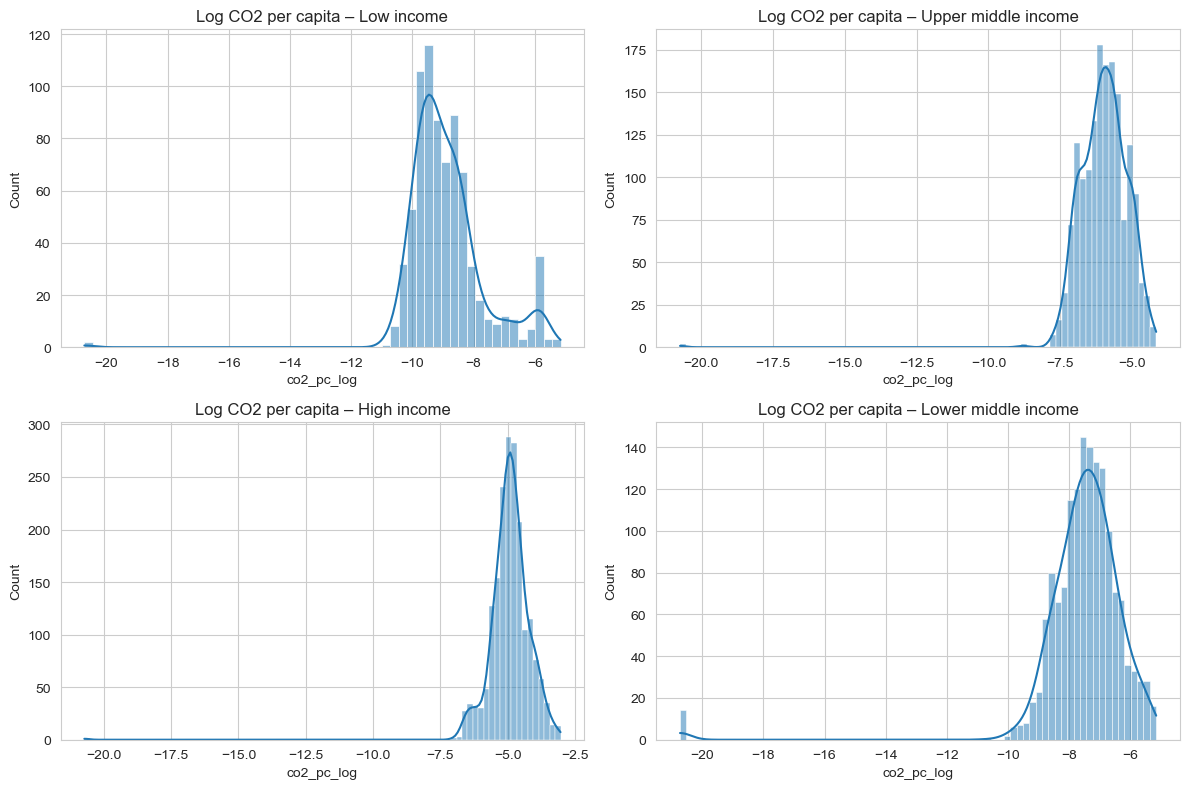

Shapiro-Wilk Normality Test (log-transformed values):

Low income                 stat=0.8052,  p-value=0.00000
Upper middle income        stat=0.7721,  p-value=0.00000
High income                stat=0.7140,  p-value=0.00000
Lower middle income        stat=0.5912,  p-value=0.00000
ANOVA Result (log-transformed CO2 per capita):

                       sum_sq      df            F  PR(>F)
C(Income_Group)  11132.420225     3.0  2837.540257     0.0
Residual          7574.515497  5792.0          NaN     NaN 

Tukey HSD Post-hoc Test:

             Multiple Comparison of Means - Tukey HSD, FWER=0.05             
       group1              group2       meandiff p-adj  lower   upper  reject
-----------------------------------------------------------------------------
        High income          Low income  -3.9662   0.0 -4.0915 -3.8408   True
        High income Lower middle income  -2.6108   0.0 -2.7121 -2.5095   True
        High income Upper middle income  -1.0743   0.0  -1.174 -0.9747   T

In [26]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# ---------------------------------------------------------
# 0. PREP — use the cleaned countries dataset
# ---------------------------------------------------------
df = df_wb_countries.copy()

# ---------------------------------------------------------
# 1. Log-transform CO2-per-capita (safe log)
# ---------------------------------------------------------
df['co2_pc_log'] = np.log(df['co2_pc'] + 1e-9)

print("Log-transformation applied.\n")

# ---------------------------------------------------------
# 2. Counts per Income Group
# ---------------------------------------------------------
print("Counts per Income Group:")
print(df['Income group'].value_counts(dropna=False), "\n")

# ---------------------------------------------------------
# 3. Histogram inspection (log-transformed)
#    — fix subplot bug by breaking after 4 plots
# ---------------------------------------------------------
plt.figure(figsize=(12,8))

for i, group in enumerate(df['Income group'].unique()):
    if i >= 4:  # you only have 4 subplot positions
        break

    subset = df[df['Income group'] == group]['co2_pc_log'].dropna()
    plt.subplot(2, 2, i+1)
    sns.histplot(subset, kde=True)
    plt.title(f"Log CO2 per capita – {group}")

plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 4. Shapiro-Wilk normality test (log-transformed)
# ---------------------------------------------------------
print("Shapiro-Wilk Normality Test (log-transformed values):\n")

# nur echte Einkommensgruppen (ohne NaN)
valid_groups = [g for g in df['Income group'].unique() if pd.notna(g)]

for group in valid_groups:
    subset = df[df['Income group'] == group]['co2_pc_log'].dropna()

    # Shapiro braucht mindestens n=3, sonst gibt es Warnungen / NaN
    if len(subset) < 3:
        print(f"{str(group):25}  too few observations for Shapiro-Wilk (n={len(subset)})")
        continue

    stat, p = stats.shapiro(subset)
    print(f"{str(group):25}  stat={stat:.4f},  p-value={p:.5f}")


# ---------------------------------------------------------
# 6. ANOVA (log-transformed)
# ---------------------------------------------------------
df_anova = df.rename(columns={'Income group': 'Income_Group'})

model = ols('co2_pc_log ~ C(Income_Group)', data=df_anova).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print("ANOVA Result (log-transformed CO2 per capita):\n")
print(anova_table, "\n")

# ---------------------------------------------------------
# 7. Tukey HSD post-hoc test (nur vollständige, saubere Zeilen)
# ---------------------------------------------------------
tukey_df = df_anova[['co2_pc_log', 'Income_Group']].dropna().copy()

# sicherstellen, dass die Gruppen nur Strings sind
tukey_df['Income_Group'] = tukey_df['Income_Group'].astype(str)

tukey = pairwise_tukeyhsd(
    endog=tukey_df['co2_pc_log'],
    groups=tukey_df['Income_Group'],
    alpha=0.05
)

print("Tukey HSD Post-hoc Test:\n")
print(tukey)


# Analysis of energy consumption between income groups

Analysis followed by statistical testing (ANOVA + Tukey HSD)

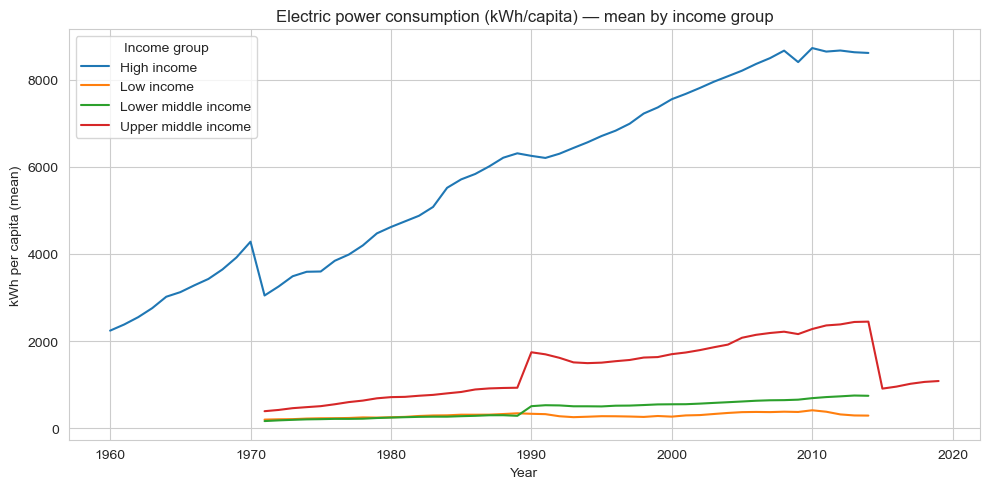

In [27]:
# Build Year from 'date'
df_wb_countries['Year'] = pd.to_datetime(df_wb_countries['date'], errors='coerce').dt.year

value_col = 'electric_power_consumption'
income_col = 'Income group'

work = df_wb_countries[
    df_wb_countries[value_col].notna()
    & df_wb_countries['Year'].notna()
    & df_wb_countries[income_col].notna()
]

pivot = (work.groupby(['Year', income_col])[value_col]
             .mean()
             .unstack(income_col)
             .sort_index())

plt.figure(figsize=(10, 5))
for col in pivot.columns:
    plt.plot(pivot.index, pivot[col], label=str(col))
plt.title("Electric power consumption (kWh/capita) — mean by income group")
plt.xlabel("Year")
plt.ylabel("kWh per capita (mean)")
plt.legend(title="Income group")
plt.tight_layout()
plt.show()


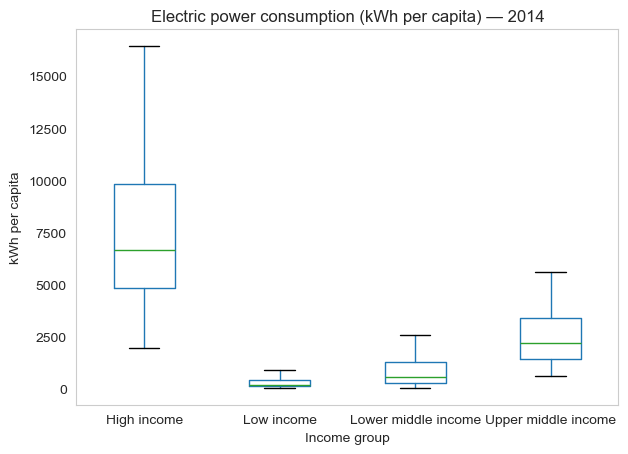

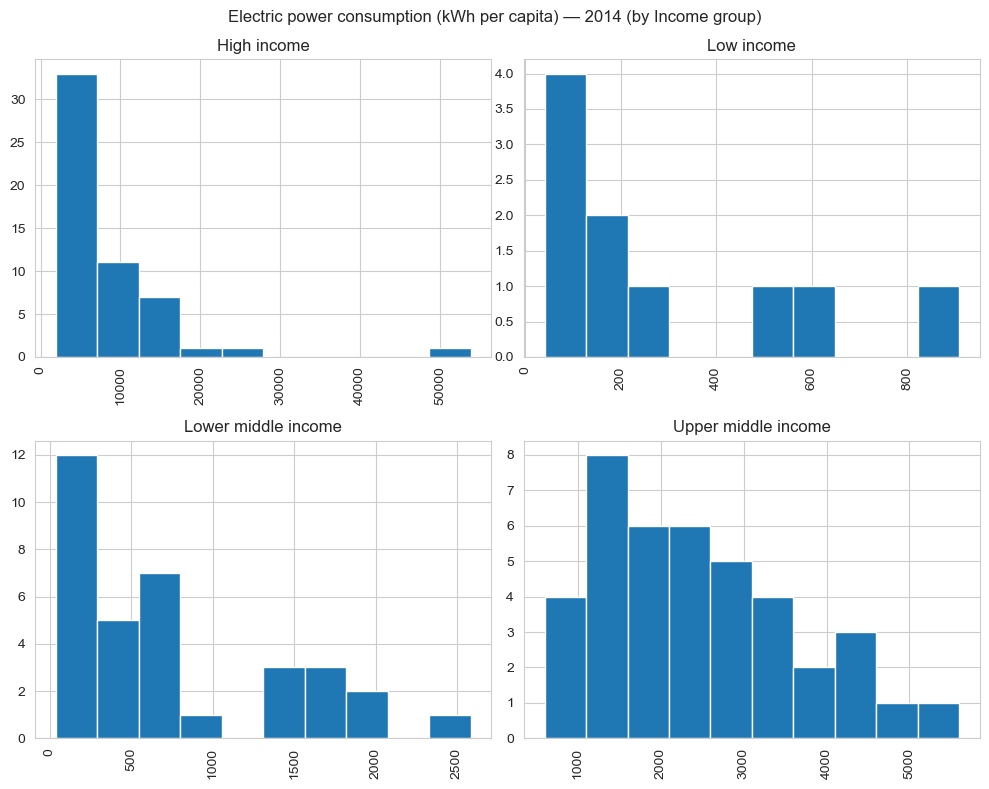

In [28]:
# Filter to 2014 and keep needed columns
df_2014 = df_wb_countries.loc[
    pd.to_datetime(df_wb_countries['date']).dt.year == 2014,
    ['Income group', 'electric_power_consumption']
].dropna()


# Single call: boxplot by income group, outliers hidden
ax = df_2014.boxplot(
    column='electric_power_consumption',
    by='Income group',
    showfliers=False,
    grid=False
)

plt.title('Electric power consumption (kWh per capita) — 2014')
plt.suptitle('')  # removes pandas default super title
plt.xlabel('Income group')
plt.ylabel('kWh per capita')
plt.tight_layout()
plt.show()

axes = df_2014.hist(
    column='electric_power_consumption',
    by='Income group',
    bins=10,
    figsize=(10, 8),
    sharex=False,
    sharey=False,
    grid=False,
)

plt.suptitle('Electric power consumption (kWh per capita) — 2014 (by Income group)')
plt.tight_layout()
plt.show()

The data shows that higher income groups tend to have higher electric power consumption per capita. The boxplot indicates that the High income group has the highest median consumption, followed by Upper-Middle, Lower-Middle, and Low income groups. The histograms reveal that the distribution of consumption values varies across income groups, with the High income group showing a wider range of consumption levels.

Nevertheless, distribution is not normally distributed so I will try to run a log transformation to make it normally distributed

In [29]:
df_2014['electric_power_consumption'] = np.where(
    df_2014['electric_power_consumption'] > 0,
    np.log10(df_2014['electric_power_consumption']),
    np.nan
)

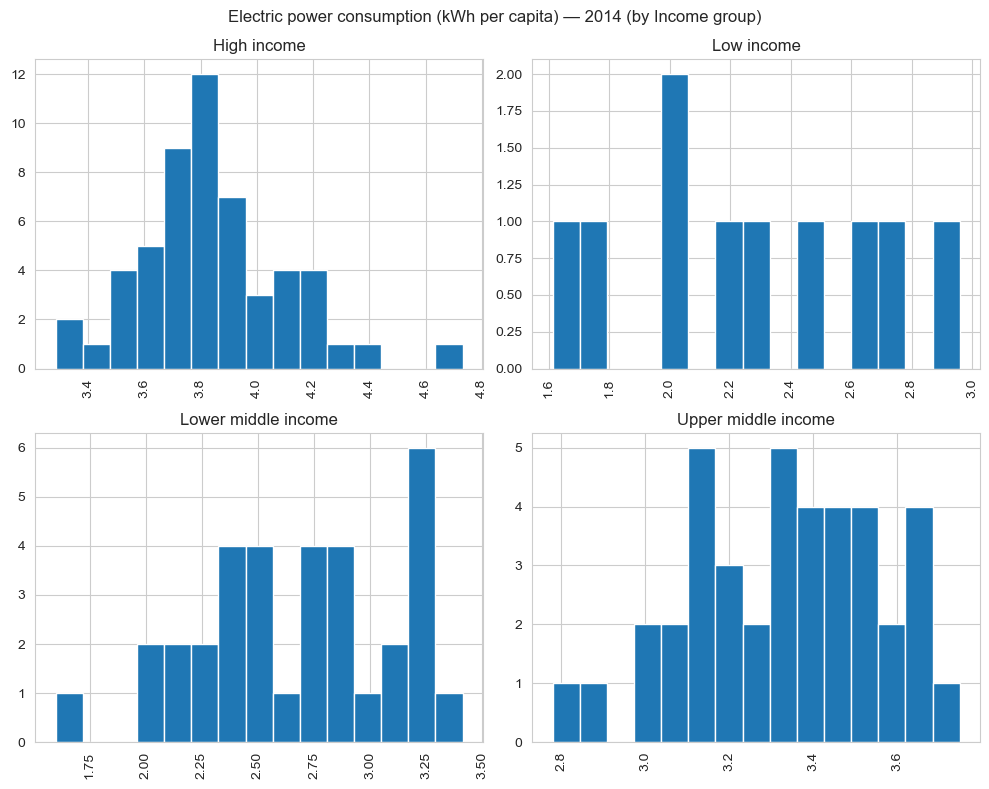

In [30]:
axes = df_2014.hist(
    column='electric_power_consumption',
    by='Income group',
    bins=15,
    figsize=(10, 8),
    sharex=False,
    sharey=False,
    grid=False,
)

plt.suptitle('Electric power consumption (kWh per capita) — 2014 (by Income group)')
plt.tight_layout()
plt.show()